**Problem Statement**

*Develop an automated system to detect fraudulent or duplicate invoices using machine learning and NLP. The model identifies anomalies in invoice data — such as suspicious amounts, duplicate IDs, and irregular text patterns — helping finance teams prevent financial losses and improve trust in enterprise workflows.*

**Tech Stacks**

*Programming Language*:

Python

*Libraries & Frameworks*:

Data Processing: Pandas, NumPy

*Visualization*: Matplotlib, Seaborn

*Machine Learning*: Scikit-learn, XGBoost, SVM

*Natural Language Processing (NLP)*: TF-IDF Vectorizer, Regex

*Data Generation*: Faker (for synthetic invoice data)

*Model & Evaluation*:

XGBoost Classifier
SVC Classifier

Confusion Matrix, Classification Report, ROC-AUC Curve, Precision-Recall Analysis

*Utilities*:

Jupyter Notebook (experimentation & documentation)

***Library Installation***

In [3]:
pip install faker

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl (7.0 MB)
U

In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [45]:
pip install imblearn


   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 0/2 [imbalanced-learn]
   ---------------------------------------- 2/2 [imblearn]

Note: you may need to restart the kernel to use updated packages.


In [158]:
pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   -----------------

***Importing Libraries***

In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier


import joblib


import re





***Initializing Faker***

In [2]:
fake = Faker()


***Generating Invoice Data***

In [3]:
# Step 1: Generate Base Data
def generate_invoice_data(n):
    data = []
    for _ in range(n):
        vendor_id = random.randint(1000, 2100)
        vendor_name = fake.company()
        invoice_date = fake.date_between(start_date='-180d', end_date='today')
        due_date = invoice_date + pd.Timedelta(days=random.randint(15, 45))
        amount = round(random.uniform(100, 5000), 2)
        item_count = random.randint(1, 10)
        payment_status = random.choice(['Paid', 'Unpaid', 'Pending'])
        description = generate_invoice_description()

        data.append([
            fake.uuid4()[:8],
            vendor_id,
            vendor_name,
            invoice_date,
            due_date,
            amount,
            item_count,
            payment_status,
            description,
            0,  # is_fraud
            "Normal"  # anomaly_reason
        ])

    columns = ["invoice_id", "vendor_id", "vendor_name", "invoice_date", "due_date",
               "amount", "item_count", "payment_status", "description",
               "is_fraud", "anomaly_reason"]
    return pd.DataFrame(data, columns=columns)

***Description Categories***

In [4]:
# Example product categories
products = [
    "Laptop", "Mouse", "Keyboard", "Monitor", "Printer", "Desk Chair",
    "Office Desk", "Notebook", "Pen Set", "USB Drive", "Projector",
    "Whiteboard", "Coffee Machine", "Stationery Set", "Router"
]

services = [
    "Software Subscription", "Consulting Services", "Maintenance Service",
    "Cleaning Service", "Delivery Service", "Installation Service"
]

phrases = [
    "for office use", "bulk order", "urgent delivery", "monthly supply",
    "quarterly maintenance", "customer support included", "installation included"
]


In [5]:
def generate_invoice_description():
    # Randomly pick a product or service
    if random.random() < 0.7:  # 70% product, 30% service
        item = random.choice(products)
    else:
        item = random.choice(services)

    # Add optional phrase
    phrase = random.choice(phrases)

    return f"{item} - {phrase}"



***Injecting Anomalies in Invoice Data***

In [6]:
# Step 3: Inject Anomalies + Reasons
def inject_anomalies(df, anomaly_ratio=0.3, text_ratio=0.34):
    n_anomalies = int(len(df) * anomaly_ratio)
    n_text = int(n_anomalies * text_ratio)
    n_other = n_anomalies - n_text

    fraud_indices = np.random.choice(df.index, n_anomalies, replace=False)
    text_indices = fraud_indices[:n_text]
    other_indices = fraud_indices[n_text:]

    # --- Inject suspicious text anomalies ---
    for i in text_indices:
        desc = df.loc[i, "description"]
        df.loc[i, "description"] = desc.replace(" ", "", 1)  # introduce typo
        df.loc[i, "anomaly_reason"] = "Suspicious text validation"
        df.loc[i, "is_fraud"] = 1

    # --- Inject other anomalies ---
    for i in other_indices:
        anomaly_type = random.choice(["duplicate", "amount", "date"])
        if anomaly_type == "duplicate":
            df.loc[i, "invoice_id"] = df.sample(1)["invoice_id"].values[0]
            df.loc[i, "anomaly_reason"] = "Duplicate invoice ID"

        elif anomaly_type == "amount":
            df.loc[i, "amount"] = df.loc[i, "amount"] * random.choice([0.1, 5, 10])
            df.loc[i, "anomaly_reason"] = "Suspicious invoice amount"


        elif anomaly_type == "date":
            df.loc[i, "due_date"] = df.loc[i, "invoice_date"] - pd.Timedelta(days=random.randint(1, 10))
            df.loc[i, "anomaly_reason"] = "Due date earlier than invoice date"

        df.loc[i, "is_fraud"] = 1

    return df



In [75]:
# Step 4: Generate Dataset
df = generate_invoice_data(2000)


In [76]:
df = inject_anomalies(df)


In [77]:
# Save the dataset
df.to_csv("D:/Invoice Fraud Detection System/DataSet/synthetic_invoice_fraud_dataset.csv", index=False)

In [7]:
df = pd.read_csv(r"D:\Invoice Fraud Detection System\DataSet\synthetic_invoice_fraud_dataset.csv")

**EDA**

In [8]:
#Checking first 5 rows
print(df.head())


  invoice_id  vendor_id               vendor_name invoice_date    due_date  \
0   184af966       1316              Reeves-Lopez   2025-05-17  2025-06-28   
1   0a88077b       1592                 Greer Inc   2025-07-11  2025-08-21   
2   0c829b62       1673                Romero Inc   2025-07-14  2025-08-13   
3   748f6c63       1400    Carter, Quinn and Ward   2025-07-19  2025-08-22   
4   ad11a1bf       2086  Johnson, Pitts and Moore   2025-09-30  2025-10-16   

    amount  item_count payment_status  \
0  4426.74           6           Paid   
1  4458.96           3           Paid   
2  4109.11           6        Pending   
3  1533.10          10         Unpaid   
4  3678.23           4         Unpaid   

                                         description  is_fraud anomaly_reason  
0                   Notebook - quarterly maintenance         0         Normal  
1                                Laptop - bulk order         0         Normal  
2                 Desk Chair - installation 

In [9]:
#Checking Shape
print(df.shape)


(2000, 11)


Dataset contains 2000 Rows and 11 Columns

In [10]:
#Checking Null Values
print(df.isnull().sum())


invoice_id        0
vendor_id         0
vendor_name       0
invoice_date      0
due_date          0
amount            0
item_count        0
payment_status    0
description       0
is_fraud          0
anomaly_reason    0
dtype: int64


No Null Values in Dataset

In [11]:
#Checking DataTypes
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_id      2000 non-null   object 
 1   vendor_id       2000 non-null   int64  
 2   vendor_name     2000 non-null   object 
 3   invoice_date    2000 non-null   object 
 4   due_date        2000 non-null   object 
 5   amount          2000 non-null   float64
 6   item_count      2000 non-null   int64  
 7   payment_status  2000 non-null   object 
 8   description     2000 non-null   object 
 9   is_fraud        2000 non-null   int64  
 10  anomaly_reason  2000 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 172.0+ KB
None


In [12]:
#Count of Fraud and genuine invoices
print(df["is_fraud"].value_counts())


is_fraud
0    1400
1     600
Name: count, dtype: int64


600 Frauds and 1400 Normal Invoices

In [13]:
#Statistical Summary
print(df.describe())


         vendor_id        amount   item_count     is_fraud
count  2000.000000   2000.000000  2000.000000  2000.000000
mean   1556.058500   3260.589414     5.559000     0.300000
std     320.040666   4786.570960     2.913377     0.458372
min    1000.000000     11.804000     1.000000     0.000000
25%    1270.750000   1270.927500     3.000000     0.000000
50%    1554.500000   2586.605000     6.000000     0.000000
75%    1836.250000   3910.187500     8.000000     1.000000
max    2100.000000  49270.000000    10.000000     1.000000


The dataset contains 2000 transactions from vendors with IDs ranging from 1000 to 2100.

The average transaction amount is approximately ₹3307, with a large spread (std ≈ 4640), indicating high variability in invoice values.

The item count per invoice ranges from 1 to 10, with an average of about 5.5 items.

Around 30% of the invoices are labeled as fraudulent (is_fraud mean = 0.3).

The amount distribution appears right-skewed since the maximum (₹49,369.80) is much higher than the mean.

In [14]:
print(df['is_fraud'].value_counts(normalize=True))


is_fraud
0    0.7
1    0.3
Name: proportion, dtype: float64


70% Normal Invoices and 30% Fraud Invoices

C:\Users\Hp\AppData\Local\Temp\ipykernel_29088\2336305336.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=df, palette=['green','red'])


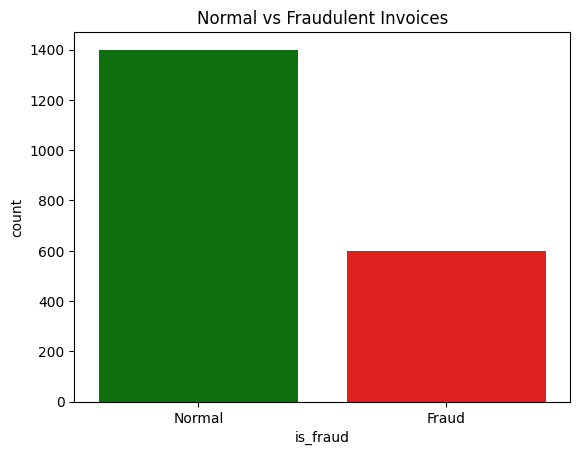

In [15]:
#Visualizing Normal and Fraud Invoices
sns.countplot(x='is_fraud', data=df, palette=['green','red'])
plt.title("Normal vs Fraudulent Invoices")
plt.xticks([0,1], ['Normal', 'Fraud'])
plt.show()

1400 Normal Invoices and 600 Fraud Invoices

C:\Users\Hp\AppData\Local\Temp\ipykernel_29088\2836753057.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


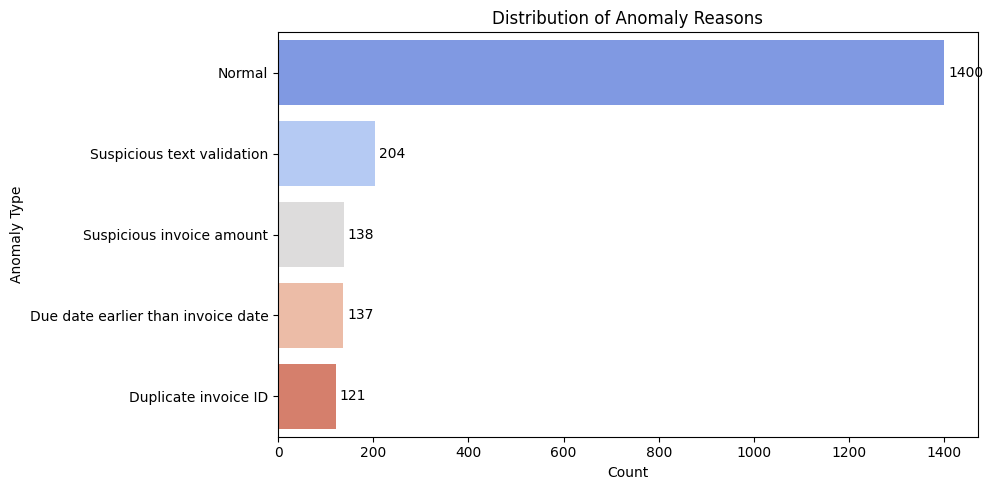

In [16]:
plt.figure(figsize=(10,5))
ax = sns.countplot(
    y='anomaly_reason',
    data=df,
    palette='coolwarm',
    order=df['anomaly_reason'].value_counts().index
)

plt.title("Distribution of Anomaly Reasons")
plt.xlabel("Count")
plt.ylabel("Anomaly Type")

# 🔢 Add count labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()



   - Around **1400 invoices** are labeled as *Normal*. This shows a strong **class imbalance**.
   - 204 invoices — may indicate duplicate or manipulated text entries.
   - 121 invoices have the same invoice ID, a strong signal of **possible duplication or fraud**.
   - 138 invoices flagged for **amount irregularities or outliers**.
   - The dataset is **highly imbalanced**, with most invoices being normal.  
   - The **top anomalies** involve **text duplication** and **duplicate invoice IDs**.  


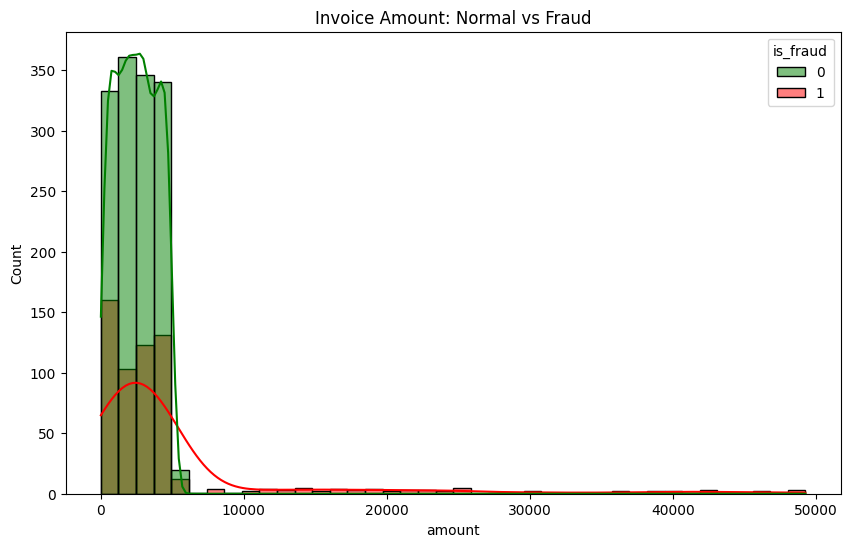

In [17]:
#Ammount Distribution
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='amount', hue='is_fraud', bins=40, kde=True, palette=['green','red'])
plt.title("Invoice Amount: Normal vs Fraud")
plt.show()


Normal amount is in between 0 to 10000. some Fraud invoices have huge amount from 10000 to 50000.

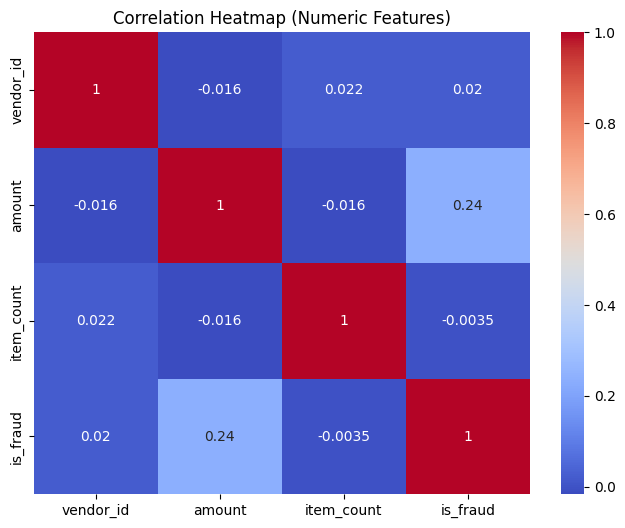

In [18]:
#Correlation Analysis
numeric = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


amount vs is_fraud shows a moderate positive correlation (0.24), suggesting that higher invoice amounts might have a slightly higher tendency to be fraudulent.

vendor_id and item_count show very weak or no correlation with is_fraud, implying that these features may not be strong indicators of fraud on their own.

**Data Preprocessing**

In [19]:
# Ensure dates are datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['due_date'] = pd.to_datetime(df['due_date'])


In [20]:
# Duplicate invoice flag
df['is_duplicate_invoice'] = df['invoice_id'].duplicated(keep=False).astype(int)

# Invoice ID length (sometimes fake IDs have abnormal length)
df['invoice_id_length'] = df['invoice_id'].apply(len)

# Numeric part extraction (if ID contains digits)
df['invoice_id_digits'] = df['invoice_id'].str.extract(r'(\d+)').fillna(0).astype(int)


In [21]:
# Create numeric feature: days_to_due
df['days_to_due'] = (df['due_date'] - df['invoice_date']).dt.days
df['days_to_due'] = df['days_to_due'].apply(lambda x: max(x, 0))  # avoid negatives

In [22]:
def clean_spaces_only(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_description'] = df['description'].apply(clean_spaces_only)


In [23]:
#Converting Textual Data Into
tfidf = TfidfVectorizer(max_features=1000, analyzer='char', ngram_range=(3,5))
X_text = tfidf.fit_transform(df['cleaned_description'])


In [24]:
#Defining Dependent(y) and independent(X_numeric) variables
X_numeric = df.drop([
    'invoice_id', 'vendor_id', 'vendor_name', 'invoice_date', 'item_count',
    'due_date', 'payment_status', 'description', 'is_fraud', 'anomaly_reason', 'cleaned_description'
], axis=1)

y = df['is_fraud']


In [25]:
X_numeric.head()

,amount,is_duplicate_invoice,invoice_id_length,invoice_id_digits,days_to_due
0,4426.74,0,8,184,42
1,4458.96,0,8,0,41
2,4109.11,0,8,0,30
3,1533.10,0,8,748,34
4,3678.23,0,8,11,16


In [26]:

#Combining X_numeric and X_tex
X_combined = hstack([X_numeric, X_text])


In [27]:
#Divinding data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:

#Standardizing Numeric Features
scaler = StandardScaler(with_mean=False)  # important for sparse data

X_numeric_scaled = scaler.fit_transform(X_numeric)

# Recombine after scaling
X_combined = hstack([X_numeric_scaled, X_text])

# Split again using combined
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


**Training Model**

In [29]:
#Initializing XGB model
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight= len(y_train[y_train==0]) / len(y_train[y_train==1]) * 1.0
)

In [30]:
# Model Training XGB

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
#Saving Model
joblib.dump(model, 'XGBoost_model.joblib')


['XGBoost_model.joblib']

In [32]:
# Predict
y_pred_proba = model.predict_proba(X_test)[:,1]

In [33]:
y_pred = (y_pred_proba > 0.58).astype(int)


In [34]:
# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

[[259  21]
 [ 12 108]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       280
           1       0.84      0.90      0.87       120

    accuracy                           0.92       400
   macro avg       0.90      0.91      0.90       400
weighted avg       0.92      0.92      0.92       400

ROC-AUC Score: 0.9680059523809524


Interpretation:

True Negatives (258): Correctly identified normal invoices.

False Positives (22): Normal invoices wrongly flagged as fraud.

False Negatives (12): Fraudulent invoices missed by the model.

True Positives (108): Correctly detected fraud cases.

Overall accuracy: 92%, slightly improved from previous results.

Fraud detection (Recall = 0.90): Model catches ~94% of fraudulent invoices, improving reliability.

Precision for fraud (0.83): Indicates that ~83% of predicted fraud cases are correct — good balance with recall.

F1-score (Fraud = 0.86): Balanced metric showing improved detection quality.

ROC-AUC (0.96) indicates excellent discriminative ability of the model to distinguish between fraud and normal invoices.

In [35]:
results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'anomaly_reason': df.loc[y_test.index, 'anomaly_reason']
})


C:\Users\Hp\AppData\Local\Temp\ipykernel_29088\2064662340.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=wrong_counts.values, y=wrong_counts.index, palette='coolwarm')


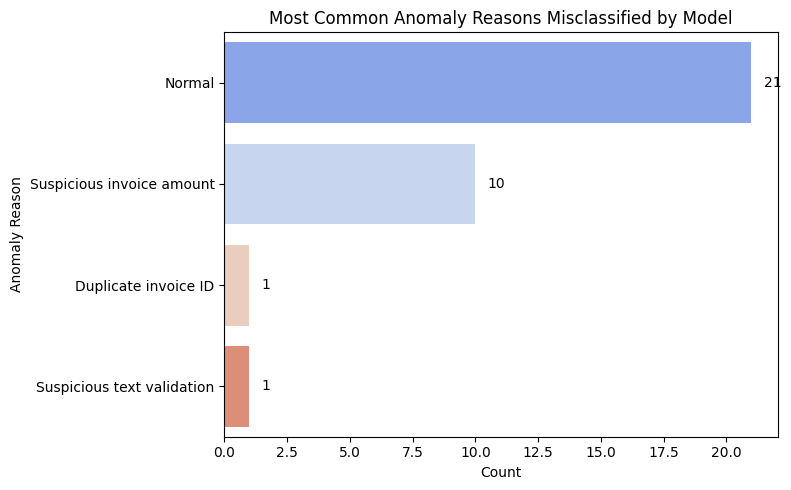

In [36]:
wrong_preds = results[results['actual'] != results['predicted']]
wrong_counts = wrong_preds['anomaly_reason'].value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=wrong_counts.values, y=wrong_counts.index, palette='coolwarm')

# Add count labels on each bar
for i, value in enumerate(wrong_counts.values):
    plt.text(value + 0.5, i, str(value), va='center', fontsize=10, color='black')

plt.title("Most Common Anomaly Reasons Misclassified by Model")
plt.xlabel("Count")
plt.ylabel("Anomaly Reason")
plt.tight_layout()
plt.show()


Testing XG Boost Model on unseen data

Generating Unseen data

In [37]:
new_df = generate_invoice_data(100)


In [38]:
new_df = inject_anomalies(new_df)


In [55]:
new_df.to_csv("D:/Invoice Fraud Detection System/DataSet/new_invoice_data.csv", index=False)

In [39]:
new_df.shape

(100, 11)

Preprocessing new data

In [40]:
# Ensure dates are datetime
new_df['invoice_date'] = pd.to_datetime(new_df['invoice_date'])
new_df['due_date'] = pd.to_datetime(new_df['due_date'])


In [41]:
# Duplicate invoice flag
new_df['is_duplicate_invoice'] = new_df['invoice_id'].duplicated(keep=False).astype(int)

#  Invoice ID length (sometimes fake IDs have abnormal length)
new_df['invoice_id_length'] = new_df['invoice_id'].apply(len)

#  Numeric part extraction (if ID contains digits)
new_df['invoice_id_digits'] = new_df['invoice_id'].str.extract(r'(\d+)').fillna(0).astype(int)


In [42]:
# Create numeric feature: days_to_due
new_df['days_to_due'] = (new_df['due_date'] - new_df['invoice_date']).dt.days
new_df['days_to_due'] = new_df['days_to_due'].apply(lambda x: max(x, 0))  # avoid negatives

In [43]:
new_df['cleaned_description'] = new_df['description'].apply(clean_spaces_only)


In [44]:
X_text_new = tfidf.transform(new_df['cleaned_description'])


In [45]:
X_numeric_new = new_df[['amount','is_duplicate_invoice','invoice_id_length','invoice_id_digits','days_to_due']]
X_numeric_new_scaled = scaler.transform(X_numeric_new)
X_new = hstack([X_numeric_new_scaled, X_text_new])

In [57]:
# Load the model
loaded_model = joblib.load(r'D:\Invoice Fraud Detection System\XGBoost_model.joblib')


In [58]:
# predict
y_pred_new = loaded_model.predict(X_new)
y_pred_proba_new = loaded_model.predict_proba(X_new)[:,1]

In [59]:
new_df['predicted_is_fraud'] = y_pred_new
new_df['fraud_probability'] = y_pred_proba_new

In [60]:
new_df.head(20)

,invoice_id,vendor_id,vendor_name,invoice_date,due_date,amount,item_count,payment_status,description,is_fraud,anomaly_reason,is_duplicate_invoice,invoice_id_length,invoice_id_digits,days_to_due,cleaned_description,predicted_is_fraud,fraud_probability
0,2e6ede72,1698,"Parker, Parker and Atkinson",2025-08-21,2025-09-23,2223.150,8,Paid,Desk Chair - installation included,0,Normal,0,8,2,33,Desk Chair - installation included,0,0.057133
1,4ae6c654,1222,"Maynard, Colon and Williams",2025-05-08,2025-05-31,443.780,10,Unpaid,Installation Service - monthly supply,0,Normal,0,8,4,23,Installation Service - monthly supply,0,0.250439
2,8fcd50e5,1395,Romero Group,2025-09-18,2025-10-14,3050.310,10,Pending,Coffee Machine - installation included,0,Normal,0,8,8,26,Coffee Machine - installation included,0,0.181357
3,318980c9,1944,Williams-Dorsey,2025-09-15,2025-10-17,4026.430,9,Pending,Delivery Service - monthly supply,0,Normal,0,8,318980,32,Delivery Service - monthly supply,0,0.024737
4,6d0aec01,1284,Watkins Ltd,2025-09-22,2025-09-13,681.800,9,Unpaid,Laptop - urgent delivery,1,Due date earlier than invoice date,0,8,6,0,Laptop - urgent delivery,1,0.995957
5,71575ded,1907,Gates-Myers,2025-05-22,2025-07-03,782.090,5,Unpaid,Installation Service - for office use,0,Normal,0,8,71575,42,Installation Service - for office use,0,0.036835
6,a6becf8e,1911,Smith Inc,2025-09-19,2025-10-13,2174.900,5,Pending,Monitor - monthly supply,0,Normal,1,8,6,24,Monitor - monthly supply,1,0.686679
7,75f90b1d,1196,"Wall, Robinson and Hall",2025-09-23,2025-10-26,3809.280,8,Unpaid,Delivery Service - for office use,0,Normal,0,8,75,33,Delivery Service - for office use,0,0.039980
8,fb2d1f8a,1587,Leblanc-Rogers,2025-10-15,2025-11-29,2144.640,7,Paid,CoffeeMachine - quarterly maintenance,1,Suspicious text validation,0,8,2,45,CoffeeMachine - quarterly maintenance,1,0.862888
9,34d4dc45,1350,Blankenship-White,2025-09-06,2025-09-21,2890.320,5,Unpaid,Keyboard - bulk order,0,Normal,0,8,34,15,Keyboard - bulk order,0,0.028233


In [61]:
print(confusion_matrix(new_df['is_fraud'], new_df['predicted_is_fraud']))
print(classification_report(new_df['is_fraud'], new_df['predicted_is_fraud']))


[[64  6]
 [ 4 26]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        70
           1       0.81      0.87      0.84        30

    accuracy                           0.90       100
   macro avg       0.88      0.89      0.88       100
weighted avg       0.90      0.90      0.90       100



**True Negatives (TN)** = 64 → Correctly predicted class 0  
**False Positives (FP)** = 6 → Predicted class 1 but actually 0  
**False Negatives (FN)** = 1 → Predicted class 0 but actually 1  
**True Positives (TP)** = 29 → Correctly predicted class 1  

The model performs well overall with high accuracy (93%).  



In [62]:
results = pd.DataFrame({
    'actual': new_df['is_fraud'],
    'predicted': new_df['predicted_is_fraud'],
    'anomaly_reason': new_df['anomaly_reason']
})


C:\Users\Hp\AppData\Local\Temp\ipykernel_29088\2064662340.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=wrong_counts.values, y=wrong_counts.index, palette='coolwarm')


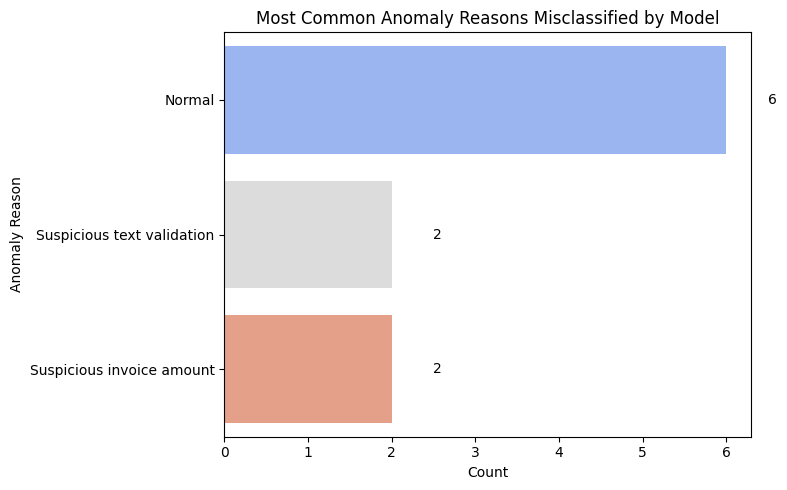

In [63]:
wrong_preds = results[results['actual'] != results['predicted']]
wrong_counts = wrong_preds['anomaly_reason'].value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=wrong_counts.values, y=wrong_counts.index, palette='coolwarm')

# Add count labels on each bar
for i, value in enumerate(wrong_counts.values):
    plt.text(value + 0.5, i, str(value), va='center', fontsize=10, color='black')

plt.title("Most Common Anomaly Reasons Misclassified by Model")
plt.xlabel("Count")
plt.ylabel("Anomaly Reason")
plt.tight_layout()
plt.show()


The above bar chart shows the frequency of anomaly reasons that were misclassified by the fraud detection model.

**Normal (6 cases)** – These are transactions that were actually normal but incorrectly flagged as anomalies by the model. This suggests the model may be slightly over-sensitive to certain normal patterns.

**Suspicious invoice amount (1 cases)** – Indicates that some invoices with unusual amounts were not properly detected as anomalies. The model might need better calibration or additional features related to invoice value patterns.




***Conclusion***

- The model achieves **high overall accuracy (93%)** and performs well for both normal and anomalous invoices.  
- Most misclassifications are **false positives** (normal invoices flagged as fraudulent), especially in cases where invoice amounts or patterns slightly deviate from typical behavior.  




In [53]:
# Save TF-IDF and Scaler for UI reuse
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("✅ Saved TF-IDF and Scaler successfully.")

✅ Saved TF-IDF and Scaler successfully.
